In [1]:
from collections import OrderedDict
import re
import os

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import torch
from tqdm.notebook import tqdm

from eval import get_run_metrics, read_run_dir, get_model_from_run
from plot_utils import basic_plot, collect_results, relevant_model_names

%matplotlib inline
%load_ext autoreload
%autoreload 2

sns.set_theme('notebook', 'darkgrid')
palette = sns.color_palette('colorblind')

run_dir = "../models"

In [2]:
df = read_run_dir(run_dir)
df  # list all the runs in our run_dir

,run_id,task,model,kwargs,num_tasks,num_examples,n_dims,n_layer,n_head,run_name
9,pretrained,decision_tree,Transformer,depth=4,-1,-1,20,12,8,decision_tree_pretrained
2,pretrained,linear_regression,Transformer,,-1,-1,20,12,8,linear_regression_pretrained
0,toy_ori,linear_regression,Transformer,,-1,-1,5,12,8,linear_regression_toy
1,toy_w1_0.9,linear_regression,Transformer,,-1,-1,5,12,8,linear_regression_toy
3,toy_w1_0.8,linear_regression,Transformer,,-1,-1,5,12,8,linear_regression_toy
7,pretrained,relu_2nn_regression,Transformer,hidden_layer_size=100,-1,-1,20,12,8,relu_2nn_regression_pretrained
4,step_5000,single_layer,single_layer,,-1,-1,20,1,1,single_layer
5,ee787f97-93f6-4cc7-9d7c-c69e5287eaf4,single_layer,single_layer,,-1,-1,20,1,1,single_layer
6,54ad81a7-ee46-4abe-b057-e9113d567f20,single_layer,single_layer,,-1,-1,20,1,1,single_layer
8,pretrained,sparse_linear_regression,Transformer,sparsity=3,-1,-1,20,12,8,sparse_regression_pretrained


In [3]:
task = "linear_regression"
#task = "sparse_linear_regression"
# task = "decision_tree"
#task = "relu_2nn_regression"

run_id = "toy_w1_0.9"  # if you train more models, replace with the run_id from the table above

run_path = os.path.join(run_dir, task, run_id)
recompute_metrics = False

if recompute_metrics:
    get_run_metrics(run_path)  # these are normally precomputed at the end of training

# Plot pre-computed metrics

run_name: linear_regression_toy, id: toy_w1_0.9
------------------------
conf: Munch({'config': 'conf/toy.yaml', 'inherit': ['/home/hlv8980/in-context-learning-fork/src/conf/models/standard.yaml', '/home/hlv8980/in-context-learning-fork/src/conf/wandb.yaml'], 'model': Munch({'family': 'gpt2', 'n_dims': 5, 'n_embd': 256, 'n_head': 8, 'n_layer': 12, 'n_positions': 11}), 'out_dir': '../models/linear_regression/6e671342-ecd1-4065-8e2b-782c67e258db', 'test_run': False, 'training': Munch({'batch_size': 64, 'curriculum': Munch({'dims': Munch({'end': 5, 'inc': 1, 'interval': 2000, 'start': 5}), 'points': Munch({'end': 11, 'inc': 2, 'interval': 2000, 'start': 11})}), 'data': 'gaussian', 'keep_every_steps': 100000, 'learning_rate': 0.0001, 'num_tasks': None, 'num_training_examples': None, 'resume_id': None, 'save_every_steps': 1000, 'task': 'linear_regression', 'task_kwargs': Munch({}), 'train_steps': 5001}), 'wandb': Munch({'entity': 'northwestern-in-context-learning', 'log_every_steps': 100, '

100%|██████████| 15/15 [00:00<00:00, 171429.32it/s]

------------------------
metrics: {'standard': {'gpt2_embd=256_layer=12_head=8': {'mean': [17.468618392944336, 5.8949666023254395, 3.9812755584716797, 2.500476360321045, 1.6597791910171509, 1.1794466972351074, 0.8500103950500488, 0.7212774157524109, 0.5323139429092407, 0.458526611328125, 0.40734559297561646], 'std': [29.215099334716797, 10.02861499786377, 7.677709102630615, 5.15402889251709, 4.957916736602783, 3.51035475730896, 2.121835708618164, 1.8157083988189697, 1.3993366956710815, 1.1603964567184448, 1.027977466583252], 'bootstrap_low': [16.259252548217773, 5.442200660705566, 3.655573606491089, 2.267390727996826, 1.446164846420288, 1.0202385187149048, 0.754057765007019, 0.635787308216095, 0.4709400236606598, 0.40800222754478455, 0.36122575402259827], 'bootstrap_high': [18.744121551513672, 6.357038974761963, 4.330935478210449, 2.751206636428833, 1.9023269414901733, 1.3469467163085938, 0.9479301571846008, 0.8117488026618958, 0.5962612628936768, 0.518379807472229, 0.4602268636226654]

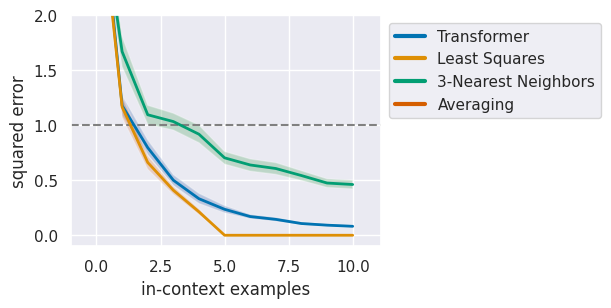

In [4]:
def valid_row(r):
    return r.task == task and r.run_id == run_id

metrics = collect_results(run_dir, df, valid_row=valid_row)
_, conf = get_model_from_run(run_path, only_conf=True)
n_dims = conf.model.n_dims

models = relevant_model_names[task]
basic_plot(metrics["standard"], models=models)
plt.show()

In [5]:
# # plot any OOD metrics
# for name, metric in metrics.items():
#     if name == "standard": continue
   
#     if "scale" in name:
#         scale = float(name.split("=")[-1])**2
#     else:
#         scale = 1.0

#     trivial = 1.0 if "noisy" not in name else (1+1/n_dims)
#     fig, ax = basic_plot(metric, models=models, trivial=trivial * scale)
#     ax.set_title(name)
    
#     if "ortho" in name:
#         ax.set_xlim(-1, n_dims - 1)
#     ax.set_ylim(-.1 * scale, 1.5 * scale)

#     plt.show()

# Interactive setup

We will now directly load the model and measure its in-context learning ability on a batch of random inputs. (In the paper we average over multiple such batches to obtain better estimates.)

In [6]:
from samplers import get_data_sampler
from tasks import get_task_sampler

In [7]:
print(conf.training.curriculum.points.end)

11


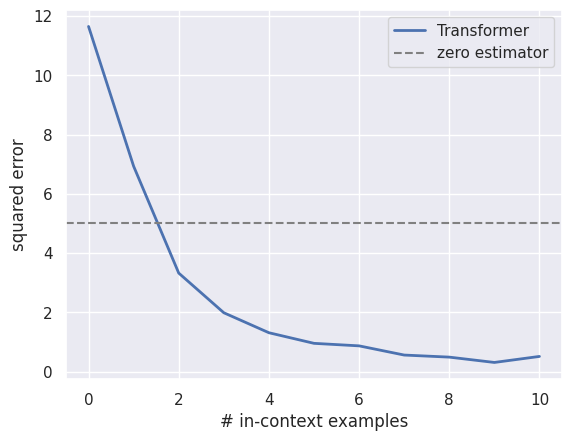

In [8]:
model, conf = get_model_from_run(run_path)

n_dims = conf.model.n_dims
batch_size = conf.training.batch_size

data_sampler = get_data_sampler(conf.training.data, n_dims)
task_sampler = get_task_sampler(
    conf.training.task,
    n_dims,
    batch_size,
    **conf.training.task_kwargs
)

task = task_sampler()
xs = data_sampler.sample_xs(b_size=batch_size, n_points=conf.training.curriculum.points.end)
ys = task.evaluate(xs)
with torch.no_grad():
    pred = model(xs, ys)
metric = task.get_metric()
loss = metric(pred, ys).numpy()

sparsity = conf.training.task_kwargs.sparsity if "sparsity" in conf.training.task_kwargs else None
baseline = {
    "linear_regression": n_dims,
    "sparse_linear_regression": sparsity,
    "relu_2nn_regression": n_dims,
    "decision_tree": 1,
}[conf.training.task]

plt.plot(loss.mean(axis=0), lw=2, label="Transformer")
plt.axhline(baseline, ls="--", color="gray", label="zero estimator")
plt.xlabel("# in-context examples")
plt.ylabel("squared error")
plt.legend()
plt.show()

As an exploration example, let's see how robust the model is to doubling all the inputs.

In [9]:
# xs2 = 2 * xs
# ys2 = task.evaluate(xs2)
# with torch.no_grad():
#     pred2 = model(xs2, ys2)
    
# loss2 = metric(pred2, ys2).numpy()

# plt.plot(loss.mean(axis=0), lw=2, label="Transformer")
# plt.plot(loss2.mean(axis=0) / 4, lw=2, label="Transformer on doubled inputs")
# plt.axhline(baseline, ls="--", color="gray", label="zero estimator")
# plt.xlabel("# in-context examples")
# plt.ylabel("squared error")
# plt.legend()
# plt.show()

The error does increase, especially when the number of in-context examples exceeds the dimension, but the model is still relatively accurate.

In [10]:
import numpy as np
model, conf = get_model_from_run(run_path)

n_dims = conf.model.n_dims
batch_size = conf.training.batch_size # this is 64
n_batches = 100

data_sampler = get_data_sampler(conf.training.data, n_dims)
task_sampler = get_task_sampler(
    conf.training.task,
    n_dims,
    batch_size,
    **conf.training.task_kwargs
)
task = task_sampler()
all_errors = []

# Generate data and perform the experiment
for _ in range(n_batches):

    xs = data_sampler.sample_xs(b_size=batch_size, n_points=2*conf.training.curriculum.points.end-1)
    ys = task.evaluate(xs)

    with torch.no_grad():
        pred = model(xs, ys)
        
    metric = task.get_metric()
    loss = metric(pred, ys).numpy()
    all_errors.append(loss)
    # error = (pred - ys) ** 2
    # all_errors.append(error.mean(axis=0).numpy())



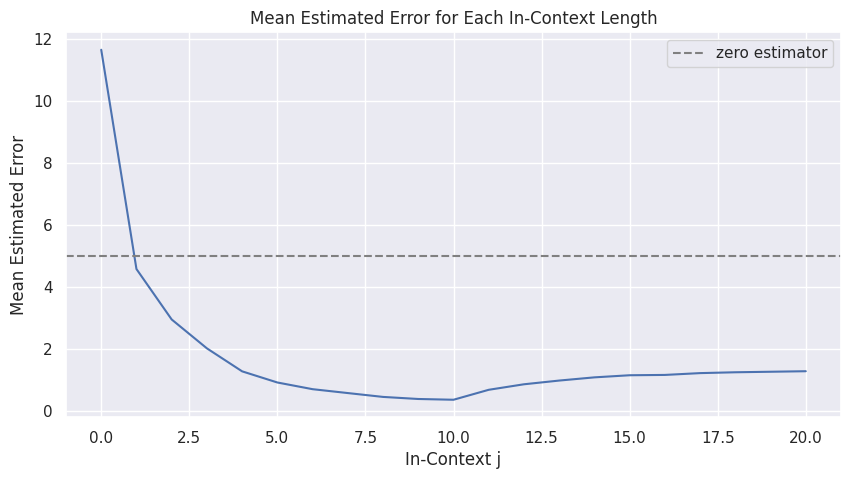

In [11]:

sparsity = conf.training.task_kwargs.sparsity if "sparsity" in conf.training.task_kwargs else None
baseline = {
    "linear_regression": n_dims,
    "sparse_linear_regression": sparsity,
    "relu_2nn_regression": n_dims,
    "decision_tree": 1,
}[conf.training.task]

mean_errors = np.mean(all_errors, axis=(0, 1))
plt.figure(figsize=(10, 5))  # Adjust the figure size as needed
plt.plot(range(21), mean_errors)
plt.axhline(baseline, ls="--", color="gray", label="zero estimator")
plt.legend()
plt.xlabel('In-Context j')
plt.ylabel('Mean Estimated Error')
plt.title('Mean Estimated Error for Each In-Context Length')
plt.show()